### EDA final project

##### In this work ,I have done the mission of food classification which I separate 3000 pictures of food into 11 categories.

#### dataset:https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0 

#### The images are collected from the food-11 dataset splitted into 11 classes
##### ● Training set: 10000 labeled images
##### ● Validation set: 3643 labeled images
##### ● Testing set: 3000 images without labeled

##### Image Classification using CNN(convolutional neural network)
###### for the Final Project Grading
###### 1.Algorithms : using RESNET101 ,one of kinds of CNN
######                optimizer:AdamW
######                scheduler:CosineAnnealingWarmRestarts
###### 2.one visualization: pie chart at the end which shows all kinds of food in testing set
###### 3.Short sentences addressing the objective(s)
###### 4.flow: load the data and packages -> dealing with the raw data -> create model -> training & valid -> try our testing datas -> get the result -> plot the result with visualization pie chart 


#### import packages

In [1]:
_exp_name = "sample"
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# This is for the progress bar.
from tqdm.auto import tqdm
import random
myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

c:\Users\justi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load dataset 

#### from:https://www.kaggle.com/competitions/ml2023spring-hw3


In [ ]:
!pip install gdown --upgrade
!wget -O food11.zip https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0
! unzip food11

#### Transforms

In [ ]:
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),

#transforms.RandomHorizontalFlip(),
#transforms.RandomRotation(30),
#transforms.RandomResizedCrop(128),

    transforms.AutoAugment(),
    transforms.ToTensor(),
    # from https://blog.csdn.net/qq_38406029/article/details/115089644
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

#### data set

In [ ]:
class FoodDataset(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
            
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 
            
        return im,label

#### Model

In [ ]:
# using github url
!pip install git+https://github.com/zhanghang1989/ResNeSt

# using pypi
!pip install resnest --pre

#use "RESNET" as algorithm
#load the model from github

# get list of models
torch.hub.list('zhanghang1989/ResNeSt', force_reload=True)

# load pretrained models, using ResNeSt-50 as an example
net = torch.hub.load('zhanghang1989/ResNeSt', 'resnest101', pretrained=False)

#### Configurations

In [ ]:
from resnest.torch import resnest101
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = resnest101(num_classes=11).to(device)

# The number of batch size.
batch_size = 16

# The number of training epochs.
# the more th epochs we have the more training time consumed 
n_epochs = 160

# If no improvement in 'patience' epochs, early stop.
patience = 30

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=2, T_mult=2, eta_min=0)

#### Dataloader

In [ ]:
# Construct train and valid datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = FoodDataset("train", tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FoodDataset("valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

#### Training

#### we can see the training procedure plot in this process

In [ ]:
import matplotlib.pyplot as plt
# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0
train_acc_res = []
val_acc_res = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()
        scheduler.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    train_acc_res.append(train_acc.item())
    val_acc_res.append(valid_acc.item())
    plt.plot(train_acc_res)
    plt.plot(val_acc_res)
    plt.show()


    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

#### Dataloader for test

In [ ]:
# Construct test datasets.
# The argument "loader" tells how torchvision reads the data.
test_set = FoodDataset("test", tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_trf = FoodDataset("test", tfm=train_tfm)
test_trf_loader = DataLoader(test_trf, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

#### Testing and generate prediction CSV

In [ ]:
model_best = resnest101(num_classes=11).to(device)
model_best.load_state_dict(torch.load('sample_best.ckpt'))
model_best.eval()
prediction = []
logit_org = []
logit_trf = []
test_pred_ensemble = []

with torch.no_grad():
    for data,_ in tqdm(test_loader):
        logit_org.append(model_best(data.to(device))) 
    for data,_ in tqdm(test_trf_loader):
        logit_trf.append(model_best(data.to(device))) 
    for i in range(len(logit_org)):
        test_pred_ensemble.append(0.8*logit_org[i] + 0.2*logit_trf[i]) 
    for i in range(len(test_pred_ensemble)):
        test_label = np.argmax(test_pred_ensemble[i].cpu().data.numpy(),axis=1)
        prediction += test_label.squeeze().tolist()

#### create test csv

In [61]:
#create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(len(test_set))]
df["Category"] = prediction
df.to_csv("result.csv",index = False)

#### create the pie chart (We operated the processes above in Kaggle)

In [65]:
import matplotlib.pyplot as plt
file = "result.csv"
data = pd.read_csv(file)
data


,Id,Category
0,0,5
1,1,1
2,2,0
3,3,3
4,4,9
...,...,...
2995,2995,1
2996,2996,3
2997,2997,0
2998,2998,6


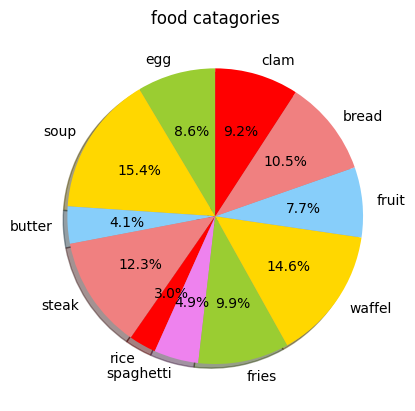

In [66]:
counts = data['Category'].value_counts().sort_index()
'''
0 as egg
1 as soup
2 as butter 
3 as steak
4 as rice
5 as spaghetti
6 as fries
7 as waffel
8 as fruit
9 as bread
10 as clam,oyster
'''

name=['egg','soup','butter','steak','rice','spaghetti','fries','waffel', 'fruit','bread','clam']
counts = [counts[0], counts[1], counts[2],counts[3] ,counts[4], counts[5],counts[6], counts[7], counts[8], counts[9], counts[10]]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','red','violet']

plt.pie(counts, labels=name,autopct='%1.1f%%', colors=colors,shadow=True, startangle=90)
plt.title("food catagories")
plt.show()
    

